### Training QSVM model on NSL-KDD dataset with Qiskit

In [2]:
# Importing the necessary modules
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Autoriser l'affichage de toutes les colonnes et lignes
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

Load NSL-KDD data

In [3]:
# Chemins vers les fichiers de dataset NSL-KDD
train_path = 'data/nsl-kdd/KDDTrain+.txt'
test_path = 'data/nsl-kdd/KDDTest+.txt'

# Colonne cibles et caractéristiques
columns = (
    ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent',
     'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
     'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
     'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
     'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
     'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
     'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
     'label']
)

# Charger les données
train_data = pd.read_csv(train_path, names=columns, sep=',', header=None, index_col=False)
test_data = pd.read_csv(test_path, names=columns , sep=',', header=None, index_col=False)

# Afficher les 5 premières lignes du jeu de données
train_data.head()

C:\Users\kiki\AppData\Local\Temp\ipykernel_14620\1072789275.py:18: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  train_data = pd.read_csv(train_path, names=columns, sep=',', header=None, index_col=False)
C:\Users\kiki\AppData\Local\Temp\ipykernel_14620\1072789275.py:19: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  test_data = pd.read_csv(test_path, names=columns , sep=',', header=None, index_col=False)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


Preprocess NSL-KDD data

In [4]:
from sklearn.preprocessing import StandardScaler
# Affiche la distribution des labels
# print(train_data['label'].value_counts())
# print(test_data['label'].value_counts())

# Prétraitement des données
def preprocess_data(data):
    # Convertir les caractéristiques catégorielles en numériques
    le = LabelEncoder()
    for column in ['protocol_type', 'service', 'flag']:
        data[column] = le.fit_transform(data[column])

    # Modifier les int64 en float64
    for column in data.select_dtypes(include=['int64']).columns:
        data[column] = data[column].astype('float64')

    # Normaliser les caractéristiques numériques sauf la colonne label
    # scaler = MinMaxScaler()
    # for column in data.columns[:-1]:
    #     data[column] = scaler.fit_transform(data[column].values.reshape(-1, 1))
    
    # Afficher les types de données
    # print(data.dtypes)

    # Séparer les caractéristiques et les labels
    X = data.drop('label', axis=1)
    # Label normal alors 0, autre (attaque) alors 1
    y = data['label'].apply(lambda x: 0 if x == 'normal' else 1)
    y = y.astype('float64') # transformer y en float64
    # print(pd.Series(y).value_counts()) # montrer la distribution des labels

    return X, y

X_train, y_train = preprocess_data(train_data)
X_test, y_test = preprocess_data(test_data)

feature_columns = X_train.columns

#Standerdize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [66]:
# Training the model
## Logistic Regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

# Test the model
accuracy = model.score(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Recall
from sklearn.metrics import recall_score
y_pred = model.predict(X_test)
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall * 100:.2f}%')

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision * 100:.2f}%')

# F1 Score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1 * 100:.2f}%')

Accuracy: 75.72%
Recall: 64.19%
Precision: 90.36%
F1 Score: 75.06%


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [6]:
## Linear Regression
# from sklearn.linear_model import LinearRegression
# model = LinearRegression()
# model.fit(X_train, y_train)

# # Test the model
# accuracy = model.score(X_test, y_test)
# print(f'Accuracy: {accuracy * 100:.2f}%')

# # Recall
# y_pred = model.predict(X_test)
# y_pred = (y_pred > 0.5)
# recall = recall_score(y_test, y_pred)
# print(f'Recall: {recall * 100:.2f}%')

# # Precision
# precision = precision_score(y_test, y_pred)
# print(f'Precision: {precision * 100:.2f}%')

# # F1 Score
# f1 = f1_score(y_test, y_pred)
# print(f'F1 Score: {f1 * 100:.2f}%')

Accuracy: 19.40%
Recall: 60.77%
Precision: 95.20%
F1 Score: 74.18%


In [67]:
## Random Forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Test the model
accuracy = model.score(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Recall
from sklearn.metrics import recall_score
y_pred = model.predict(X_test)
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall * 100:.2f}%')

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision * 100:.2f}%')

# F1 Score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1 * 100:.2f}%')

Accuracy: 74.95%
Recall: 57.92%
Precision: 96.77%
F1 Score: 72.47%


In [89]:
## Decision Tree
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=5, criterion='entropy', splitter='best')
model.fit(X_train, y_train)

# Test the model
accuracy = model.score(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Recall
from sklearn.metrics import recall_score
y_pred = model.predict(X_test)
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall * 100:.2f}%')

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision * 100:.2f}%')

# F1 Score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1 * 100:.2f}%')

# Enregistrement du modèle
import joblib
joblib.dump(model, 'data/model/dt_model.pkl') # enregistrement du modèle

Accuracy: 81.94%
Recall: 71.50%
Precision: 95.68%
F1 Score: 81.84%


['data/model/dt_model.pkl']

In [9]:
# ## Support Vector Machine
# from sklearn.svm import SVC
# model = SVC()
# model.fit(X_train, y_train)

# # Test the model
# accuracy = model.score(X_test, y_test)
# print(f'Accuracy: {accuracy * 100:.2f}%')

# # Recall
# from sklearn.metrics import recall_score
# y_pred = model.predict(X_test)
# recall = recall_score(y_test, y_pred)
# print(f'Recall: {recall * 100:.2f}%')

# # Precision
# from sklearn.metrics import precision_score
# precision = precision_score(y_test, y_pred)
# print(f'Precision: {precision * 100:.2f}%')

# # F1 Score
# from sklearn.metrics import f1_score
# f1 = f1_score(y_test, y_pred)
# print(f'F1 Score: {f1 * 100:.2f}%')

In [90]:
## K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X_train, y_train)

# Test the model
accuracy = model.score(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Recall
from sklearn.metrics import recall_score
y_pred = model.predict(X_test)
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall * 100:.2f}%')

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision * 100:.2f}%')

# F1 Score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1 * 100:.2f}%')

Accuracy: 75.93%
Recall: 60.01%
Precision: 96.31%
F1 Score: 73.94%


In [92]:
## Naive Bayes
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)

# Test the model
accuracy = model.score(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Recall
from sklearn.metrics import recall_score
y_pred = model.predict(X_test)
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall * 100:.2f}%')

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision * 100:.2f}%')

# F1 Score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1 * 100:.2f}%')

Accuracy: 57.54%
Recall: 71.95%
Precision: 60.72%
F1 Score: 65.86%


(22544, 41, 2)


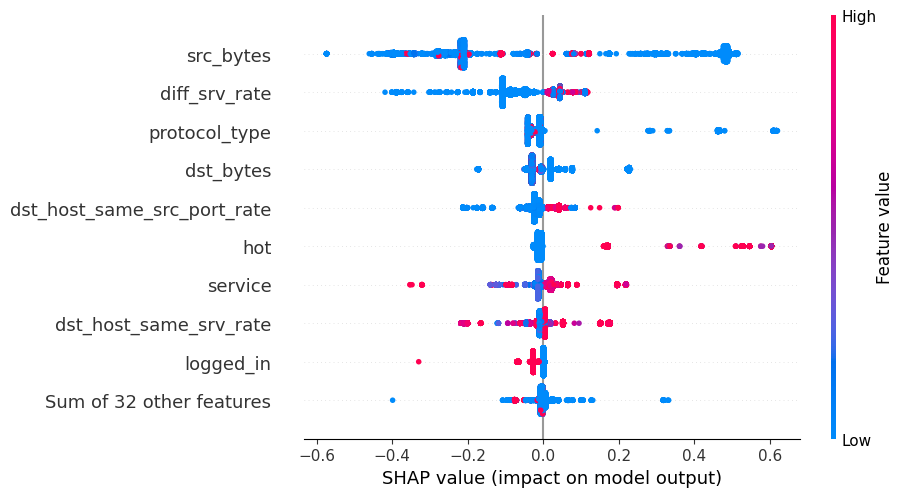

In [120]:
# Load the model
model = joblib.load('data/model/dt_model.pkl') # chargement du modèle

# Utilisation de shap pour expliquer les prédictions
import shap
explainer = shap.Explainer(model, feature_names=feature_columns)
shap_values = explainer(X_test)
print(shap_values.shape)

# Sélectionner les valeurs SHAP pour les classes
# shap_values_class_0 = shap_values[:, :, 0]
shap_values_class_1 = shap_values[:, :, 1]

# Afficher les valeurs du premier exemple
# shap.plots.waterfall(shap_values_class[0])

# Afficher les valeurs shap summary_plot
# shap.summary_plot(shap_values_class_0, X_test)
shap.summary_plot(shap_values_class_1, X_test)
# shap.plots.beeswarm(shap_values_class_1)

In [34]:
X_train, y_train = preprocess_data(train_data)
X_test, y_test = preprocess_data(test_data)

# Liste des noms des colonnes à conserver
# important_columns = [
#     "src_bytes", "diff_srv_rate", "protocol_type", "dst_bytes",
#     "dst_host_same_src_port_rate", "hot", "service",
#     "dst_host_same_srv_rate", "logged_in", "duration",
#     "dst_host_srv_serror_rate", "count", "flag", "dst_host_count",
#     "dst_host_srv_count", "dst_host_diff_srv_rate"
# ]


important_columns = [
    "src_bytes", "diff_srv_rate", "protocol_type", "dst_bytes",
]

# important_columns = [
#     "same_srv_rate", "hot", "num_access_files", "diff_srv_rate",
# ]

# Sélectionner les colonnes importantes
X_train_important = X_train[important_columns]
X_test_important = X_test[important_columns]

# Afficher le nom des colonnes
print(X_train_important.columns)

#Standerdize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_important)
X_test = scaler.transform(X_test_important)

Index(['src_bytes', 'diff_srv_rate', 'protocol_type', 'dst_bytes'], dtype='object')


In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score, f1_score
import joblib

# Entraîner le modèle avec les colonnes importantes
model = DecisionTreeClassifier(max_depth=2)
model.fit(X_train, y_train)

# Test the model
accuracy = model.score(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Recall
y_pred = model.predict(X_test)
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall * 100:.2f}%')

# Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision * 100:.2f}%')

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1 * 100:.2f}%')

# Enregistrement du modèle
joblib.dump(model, 'data/model/dt_model_important.pkl') # enregistrement du modèle

Accuracy: 82.73%
Recall: 73.81%
Precision: 94.67%
F1 Score: 82.95%


['data/model/dt_model_important.pkl']

Creation of the quantum circuit

Shape:  16


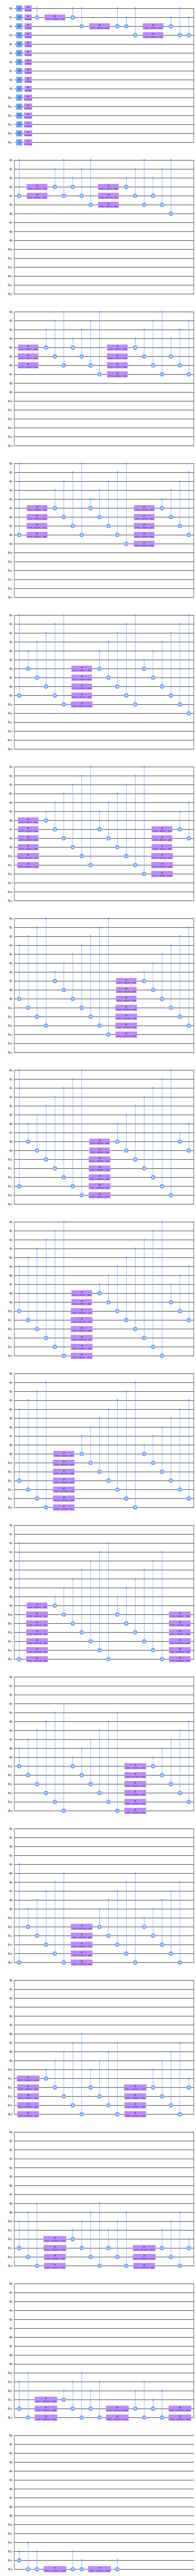

In [130]:
# Création du circuit quantique avec ZZFeatureMap
from qiskit.circuit.library import ZZFeatureMap

num_features = X_train_important.shape[1]
print("Shape: ", num_features)

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1) # 16 est le nombre de colonnes importantes
feature_map.decompose().draw(output="mpl", fold=20)

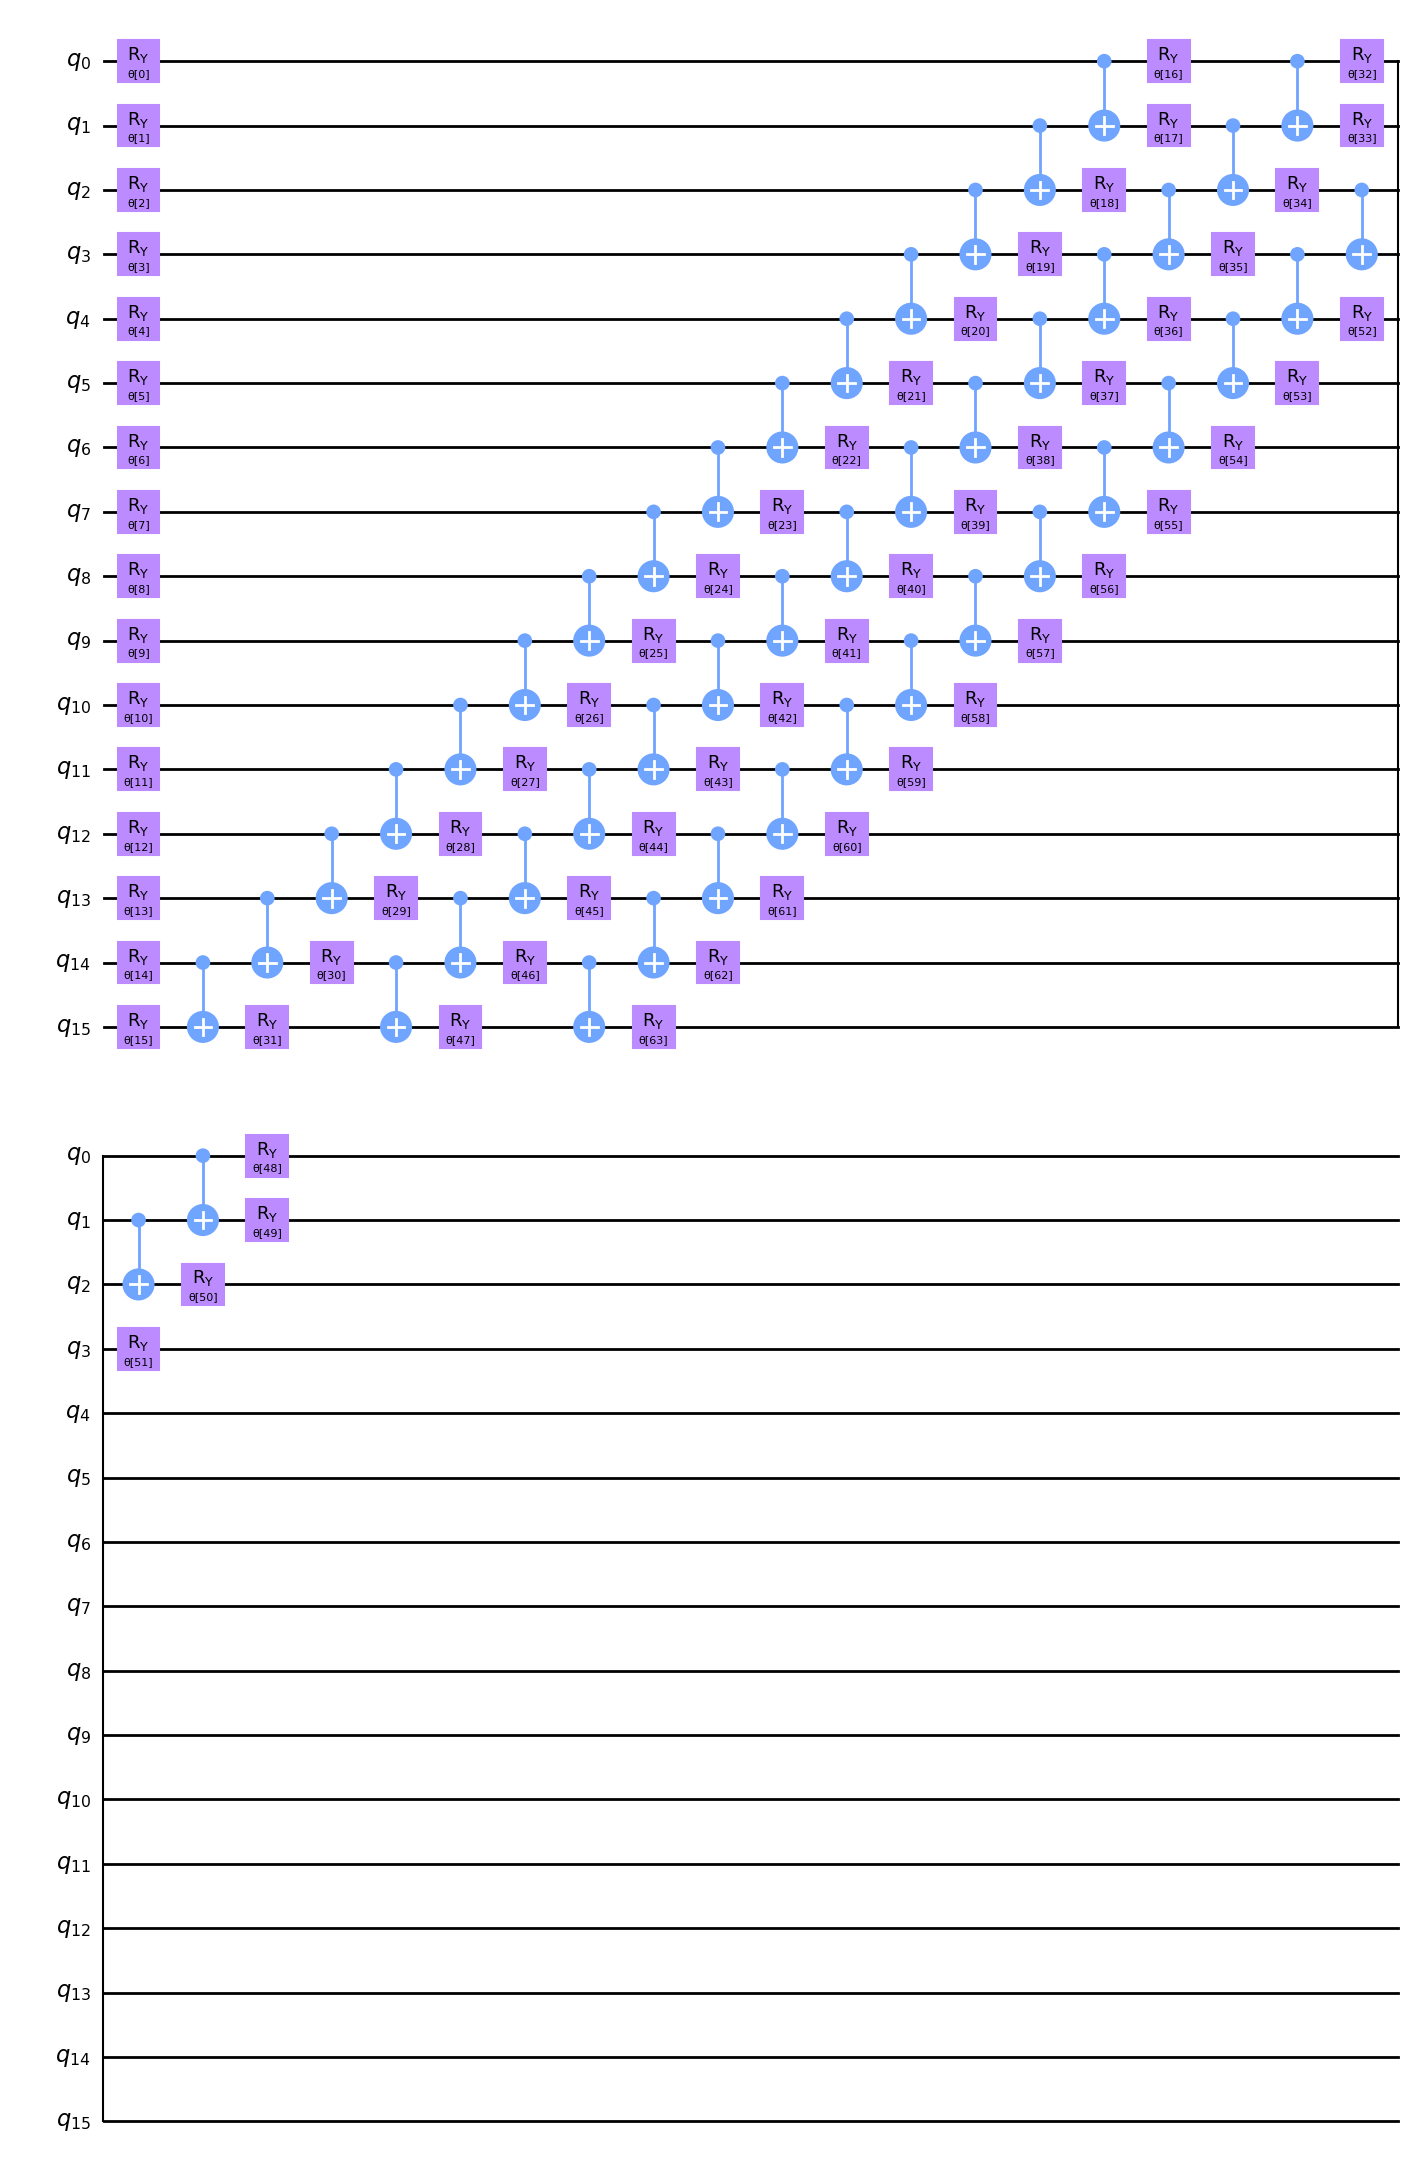

In [131]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", fold=20)

In [132]:
from qiskit_algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100) # COBYLA is an optimization algorithm used in the training process. To make the training process faster, we choose a gradient-free optimizer.

In [133]:
from qiskit.primitives import Sampler

sampler = Sampler() # The sampler is used to train our classifier on a quantum computer simulator. 

In [139]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

# print(type(X_train))
# print(type(y_train))
y_train = y_train.to_numpy()

start = time.time()
vqc.fit(X_train, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

Configuring the Quantum Instance

In [ ]:
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)


Creating the QSVM model

In [ ]:
qsvm = QSVM(feature_map, training_input, test_input, total_array, multiclass_extension=AllPairs())


Model training

In [ ]:
result = qsvm.run(quantum_instance)


Model evaluation

In [ ]:
print(f'Testing success ratio: {result["testing_accuracy"]}')
